In [38]:
import glob
import pandas as pd
import numpy as np
import sknetwork as skn
from itertools import product
from scipy.sparse.csr import csr_matrix
from sknetwork.clustering import PropagationClustering, BiPropagationClustering
from sknetwork.data import karate_club

# 20210201

The goal of this notebook is to address the data normalization problem with files in [../data/all_stab_scores](../data/all_stab_scores). In short, I want to partition stability score CSV files such that each partition has its own Data Resource and schema. The columns in schema should be as "close" to the non-empty columns in the files of the partition as possible. At the same time, we want as few partitions as possible (otherwise, optimal solution would be a single Data Resource for each CSV file).

I think I can phrase this as a graph problem. Nodes are CSV files, edges are undirected, with integer weights that refer to the number of columns that two files share. Then, partition the graph into subgraphs using some clustering algorithm. The [`scikit` algorithms](https://scikit-network.readthedocs.io/en/latest/reference/clustering.html) are probably a good starting point.

----

First step is to represent these files as a graph:

In [2]:
primary_keys = ['dataset', 'name']

In [3]:
all_fps = glob.glob("../data/all_stab_scores/og/*.csv")
all_fps

['../data/all_stab_scores/og/topology_mining_rd2.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/181114_IL_binders_FS.v2.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Inna.v7.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin_scrambled_controls_display_vector_2.rd4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin_display_vector_2.rd4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin.rd1.v4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Eva1_scrambled_controls.v3.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Eva2.v7.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin.rd3.v4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/100K_winter19.v3.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin.rd4.v4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Longxing_scrambled_controls.v3

Get columns (excluding primary keys) in each CSV file, and assign an integer index for convenience:

In [4]:
def get_cols(fp, primary_keys: list = primary_keys) -> list:
    """Get columns in CSV file `fp`, and remove primary keys"""
    all_cols = pd.read_csv(fp).columns.tolist()
    return [c for c in all_cols if c not in primary_keys]
col_dict = {int_idx: get_cols(fp) for int_idx, fp in enumerate(all_fps)}

/Users/TASethanho/.pyenv/versions/3.8.3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3341: DtypeWarning: Columns (89) have mixed types.Specify dtype option on import or set low_memory=False.
  await eval(code_obj, self.user_global_ns, self.user_ns)


Set up a weighted adjacency matrix:

In [5]:
adj = np.zeros(shape=[len(all_fps), len(all_fps)], dtype=int)

Iterate over every pair of files `(n1, n2)`:

In [6]:
for k1, k2 in product(*[list(col_dict.keys())] * 2):
    if k1 == k2:
        continue
    cols1 = set(col_dict[k1])
    cols2 = set(col_dict[k2])
    adj[k1, k2] = len(cols1.intersection(cols2))

In [47]:
adj

array([[  0,  86,   7,  87,  87,  15,  87,   7,  15,  87,  15,  87,  15,
          7,  87,  14,  87,  88,  87,   1,  15,  15,  87,   7],
       [ 86,   0,   7,  86,  86,  16,  87,   7,  16,  87,  16,  87,  16,
          7,  87,  15,  87,  87,  86,   1,  16,  15,  87,   7],
       [  7,   7,   0,   7,   7,  12,  22,  22,  12,  22,  12,  22,  12,
         22,  22,   6,  12,   7,   7,   1,  12,  22,  22,  22],
       [ 87,  86,   7,   0,  88,  15,  87,   7,  15,  87,  15,  87,  15,
          7,  87,  14,  87,  87,  87,   1,  15,  15,  87,   7],
       [ 87,  86,   7,  88,   0,  15,  87,   7,  15,  87,  15,  87,  15,
          7,  87,  14,  87,  87,  87,   1,  15,  15,  87,   7],
       [ 15,  16,  12,  15,  15,   0,  21,  12,  22,  21,  22,  21,  22,
         12,  21,  15,  21,  16,  15,   1,  22,  21,  21,  12],
       [ 87,  87,  22,  87,  87,  21,   0,  22,  21, 105,  21, 103,  21,
         22, 105,  15,  93,  88,  87,   1,  21,  30, 111,  22],
       [  7,   7,  22,   7,   7,  12,  22

In [45]:
threshold = 70
adj_bool = (adj > threshold)

In [46]:
adj_bool

array([[False,  True, False,  True,  True, False,  True, False, False,
         True, False,  True, False, False,  True, False,  True,  True,
         True, False, False, False,  True, False],
       [ True, False, False,  True,  True, False,  True, False, False,
         True, False,  True, False, False,  True, False,  True,  True,
         True, False, False, False,  True, False],
       [False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False],
       [ True,  True, False, False,  True, False,  True, False, False,
         True, False,  True, False, False,  True, False,  True,  True,
         True, False, False, False,  True, False],
       [ True,  True, False,  True, False, False,  True, False, False,
         True, False,  True, False, False,  True, False,  True,  True,
         True, False, False, False,  True, False],
       [False, False, False, False,

## Visualize Graph

In [58]:
svg_fp = "./adj_bool.svg"
labels = list(col_dict.keys())
svg_str = skn.visualization.graphs.svg_graph(adjacency=adj_bool_csr, labels=labels, display_edges=True)
with open(svg_fp, 'w') as f:
    f.write(svg_str)

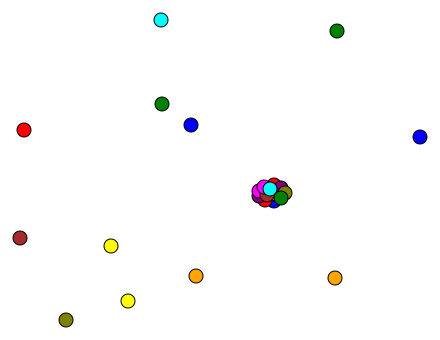

In [59]:
from IPython.core.display import SVG
SVG(filename='adj_bool.svg')

## Run Propogation Clustering On Weighted Adjacency Matrix

In [36]:
karate_club().toarray()

array([[False,  True,  True, ...,  True, False, False],
       [ True, False,  True, ..., False, False, False],
       [ True,  True, False, ..., False,  True, False],
       ...,
       [ True, False, False, ..., False,  True,  True],
       [False, False,  True, ...,  True, False,  True],
       [False, False, False, ...,  True,  True, False]])

In [31]:
adj_bool_csr = csr_matrix(adj_bool)
adj_bool_csr

<24x24 sparse matrix of type '<class 'numpy.bool_'>'
	with 132 stored elements in Compressed Sparse Row format>

In [44]:
propagation = PropagationClustering(weighted=True)
labels = propagation.fit_transform(adjacency)
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

## Testing Propagation Clustering in sknetwork

In [8]:
cols_by_fp = []

In [42]:
from sknetwork.clustering import PropagationClustering
from sknetwork.data import karate_club
propagation = PropagationClustering(weighted=True)
graph = karate_club(metadata=True)
adjacency = graph.adjacency
labels = propagation.fit_transform(adjacency)
len(set(labels))

2

In [10]:
len(labels)

34

In [16]:
adjacency.shape

(34, 34)